In [130]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as c

In [ ]:
tunnelMapData = pickle.load(open("./synthetic_data/variable/image_dataset_24.pickle","rb"))
groundTruthData = pickle.load(open("./synthetic_data/variable/ground_truth_dataset_24.pickle","rb"))
frontierVectorData = pickle.load(open("./synthetic_data/variable/frontier_dataset_24.pickle","rb"))
maskData = pickle.load(open("./synthetic_data/variable/mask_dataset_24.pickle","rb"))

In [131]:
def get_list_of_index_tuples(dim_1=24, dim_2=24):
    index_tuples = []
    for j in range(dim_2):
        for i in range(dim_1):
            index_tuples.append((i,j))
    return index_tuples

def get_nodes_and_edges_list_for_graph(Image, list_of_index_tuples):    
    dim_1, dim_2 = Image.shape
    nodes_list = []
    edges_list = []
    for i, p_1 in enumerate(list_of_index_tuples):
        if(Image[p_1]):
            nodes_list.append(p_1)
            
        for j, p_2 in enumerate(nodes_list):
            diff = np.abs(np.array(p_1)-np.array(p_2)).sum()
            
            if(diff==1 and Image[p_1] and Image[p_2]):
                edges_list.append((p_1, p_2))

    return nodes_list, edges_list      

def get_index(nodes_list, origin):
    for i in range(len(nodes_list)):
        if(nodes_list[i]==origin):
            return i
    return -1    

def plot_cur_pos(cur, prev, axes):    
    direction = np.array(cur) - np.array(prev)
    axes.arrow(prev[1],prev[0], direction[1], direction[0], color='b', ls='--', width=0.1)
    
def plot_path(Image, origin, dest, path):
    fig, axes = plt.subplots(1,1, figsize=(12,12))
    axes.imshow(Image, cmap='gray')
    axes.plot(origin[1], origin[0], marker="s", color="r",markersize=20)
    axes.plot(dest[1], dest[0], marker="*", color="g", markersize=20)

    for i in range(1, len(path)):
        plot_cur_pos(path[i], path[i-1], axes)
    plt.show()        

In [109]:
image = np.load('image.npy')

In [110]:
origin = (0, 13)
dest = (14, 16)

In [111]:
G = nx.Graph()
list_of_index_tuples = get_list_of_index_tuples(24, 24)
nodes_list, edges_list = get_nodes_and_edges_list_for_graph(image, list_of_index_tuples)
G.add_nodes_from(nodes_list)
G.add_edges_from(edges_list)

In [112]:
path = nx.shortest_path(G, origin, dest)

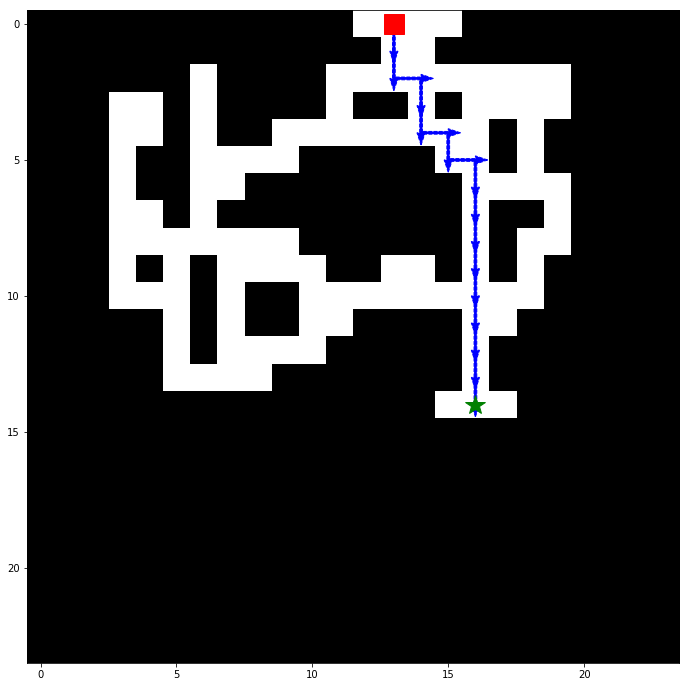

In [115]:
plot_path(image, origin, dest, path)

In [122]:
def get_cost_matrix(G, nodes_list):
    cost_matrix = np.zeros((len(nodes_list), len(nodes_list)))
    for i,n1 in enumerate(nodes_list):
        for j,n2 in enumerate(nodes_list):
            if(i!=j):
                cost_matrix[(i,j)] = nx.shortest_path_length(G, n1, n2)
            else:    
                cost_matrix[(i,j)] = 1000
    return cost_matrix            

In [123]:
cost_matrix = get_cost_matrix(G, nodes_list)

In [132]:
len(nodes_list)

110

In [135]:
origin_index = get_index(nodes_list, origin)

In [ ]:
num_nodes= len(nodes_list) #number of nodes in the Orienteering
try_times=range(90,100,20) #the time horizons which we try out

for total_time in try_times: #try it for different time horizons
    score_vector=np.ones(num_nodes) #this will generate a random score matrix.
    score_vector[origin_index]=0 #since the 0th node, start node, has no value!
    
    x=c.Variable((num_nodes,num_nodes),boolean=True) #x_ij is 1, if we travel from i to j in the tour.
    
    u=c.Variable(num_nodes) #variables in subtour elimination constraints
    
    cost=c.sum(c.matmul(cost_matrix,x)) #total cost of the tour
    profit=c.sum(c.matmul(x,score_vector))
    
    ones_arr=np.ones([num_nodes]) #array for ones
      
    constraints=[]
    
    #now, let us make sure each node is visited only once, and we leave only once from that node.
    
    constraints.append(c.sum(x[origin_index,:])==1)  #we leave from the first node
    constraints.append(c.sum(x[:,origin_index])==1) #we come back to the first node
    
    constraints.append(c.matmul(x.T,ones_arr)<=1)  #max one connection outgoing and incoming
    constraints.append(c.matmul(x,ones_arr)<=1)
    
    for i in range(num_nodes):
        constraints.append(c.sum(x[:,i])==c.sum(x[i,:]))
    #let us add the time constraints
    
    constraints.append(cost<=total_time)
    #Let us add the subtour elimination constraints (Miller-Tucker-Zemlin similar formulation)
    print('adding_subtour_constrains')
    for i in range(1,num_nodes):
        for j in range(1,num_nodes):
            if i!=j:
                constraints.append((u[i]-u[j]+1)<=((num_nodes-1)*(1-x[i,j])))
        if(i!=origin_index):
            constraints.append(u[i]<=num_nodes)    
        else:
            constraints.append(u[i]==1)    
    print('finished_adding_subtour_constrains')
    prob=c.Problem(c.Maximize(profit),constraints)
    
    prob.solve()
    print('done')
    if np.any(x.value==None): #no feasible solution found!
        
        print('Feasible solution not found, lower your time constraint!') 
        sys.exit()
    
    #print(x.value.astype('int32'))
    #print(cost_matrix)
    
    
    tour=[nodes_list[origin_index]] #.the final tour we have found will be stored here. Initialize with start node.
    
    now_node=origin_index #Initialize at start node
        
    cumulative_weight = 0
    while(cumulative_weight<=total_time): #till we reach end node
        
        next_node=np.argmax(x.value[now_node,:]) #where  we go from node i
        print('next_node, val\n',nodes_list[now_node], '->', nodes_list[next_node], x.value[now_node, next_node])
        print('cost: ', cost_matrix[now_node,next_node])

        cumulative_weight += int(cost_matrix[now_node,next_node]) 
        tour.append(nodes_list[next_node]) #for 1 based indexing
        now_node=next_node
     
    print('Profit of tour found by the solver is {}, cost of it is {} '.format(prob.value,cost.value))
    print('Time taken to solve the problem instance after formulation is {} seconds'.format(prob.solver_stats.solve_time))
    break;

adding_subtour_constrains
finished_adding_subtour_constrains


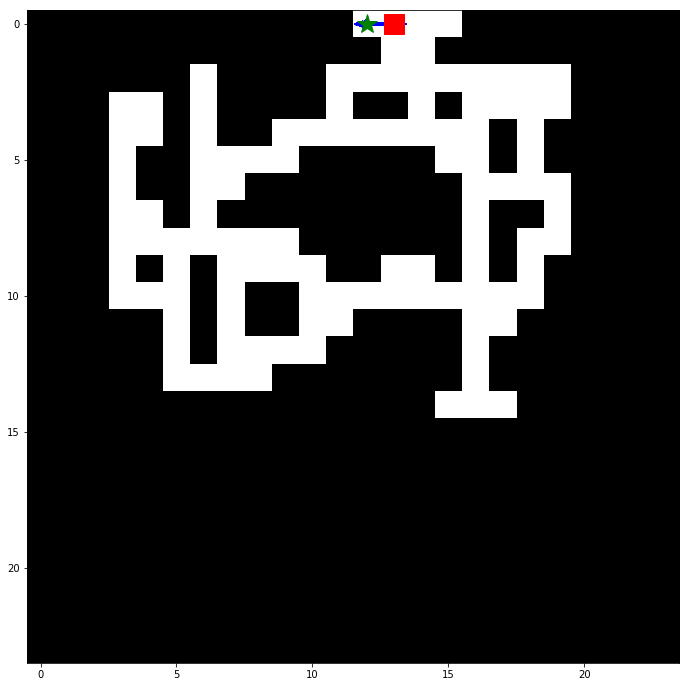

In [157]:
plot_path(image, tour[0], tour[-1], tour)

In [47]:


'''
def get_index_tuples_as_a_list(dim_1, dim_2):
    index_tuples = []
    for j in range(dim_2):
        for i in range(dim_1):
            index_tuples.append((i,j))
    index_tuples = np.array(index_tuples)        
    return index_tuples
'''


def get_adj_matrix(Image):    
    dim_1, dim_2 = Image.shape
    index_tuples = get_index_tuples_as_a_list(dim_1, dim_2)
    
    adj_matrix = np.ones((len(index_tuples), len(index_tuples)))*100

    for i, p_1 in enumerate(index_tuples):
        for j, p_2 in enumerate(index_tuples):
            diff = np.abs(p_1-p_2).sum()
            
            if(diff<2):
                if(diff==0):
                    adj_matrix[(i,j)] = 0
                elif(diff==1 and Image[tuple(p_1)] and Image[tuple(p_2)]):
                    adj_matrix[(i,j)] = 10

    return adj_matrix, index_tuples             

In [24]:
adj_matrix, index_tuples = get_adj_matrix(image)

In [ ]:
#path = tspsolve.nearest_neighbor(adj_matrix)
#new_path = tspsolve.two_opt(adj_matrix, path=path, verbose=True)

In [25]:
path = solve_tsp(adj_matrix, endpoints = (288, 287))

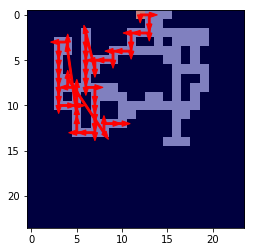

In [34]:
prev_pos = res_path[0]
fig, axes = plt.subplots(1,1)
axes.imshow(image, cmap='gray')
overlay = np.zeros((24,24))
overlay[prev_pos] = 1
axes.imshow(overlay, 'jet', interpolation='none', alpha=0.5)

steps=0
for val in res_path:
    steps+=1
    plot_cur_pos(val, prev_pos, axes)
    prev_pos = val 
    if(steps>50):
        break
plt.show()        

In [ ]:
'''
from tspy import TSP
from tspy.solvers import TwoOpt_solver

tsp = TSP()
tsp.read_mat(r1)

two_opt = TwoOpt_solver(initial_tour='NN', iter_num=100)
two_opt_tour = tsp.get_approx_solution(two_opt)
best_sol = tsp.get_best_solution()
'''